In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_parquet('../Dataset/consumercomplaints_dropna_reducedcolumns.parquet')
data.head(5)

,Product,Consumer complaint narrative
3,Checking or savings account,"Hi, I have been banking with Wells Fargo for o..."
11,Debt collection,XXXX is attempting to collect funds for Valuat...
15,"Credit reporting, credit repair services, or o...",Today I called to get my balance and reset my ...
51,"Credit reporting, credit repair services, or o...",The Federal Trade Commission Bureau of Consume...
72,"Credit reporting, credit repair services, or o...",Ive mailed police report called been hung up o...


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887808 entries, 3 to 3101964
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       887808 non-null  object
 1   Consumer complaint narrative  887808 non-null  object
dtypes: object(2)
memory usage: 20.3+ MB


In [5]:
data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    507582
Debt collection                                                                 192045
Credit card or prepaid card                                                      80410
Checking or savings account                                                      54192
Student loan                                                                     32697
Vehicle loan or lease                                                            19874
Payday loan, title loan, or personal loan                                         1008
Name: Product, dtype: int64

In [6]:
data.isnull().sum()

Product                         0
Consumer complaint narrative    0
dtype: int64

[Text(0, 0, '54192'),
 Text(0, 0, '192045'),
 Text(0, 0, '507582'),
 Text(0, 0, '80410'),
 Text(0, 0, '32697'),
 Text(0, 0, '19874'),
 Text(0, 0, '1008')]

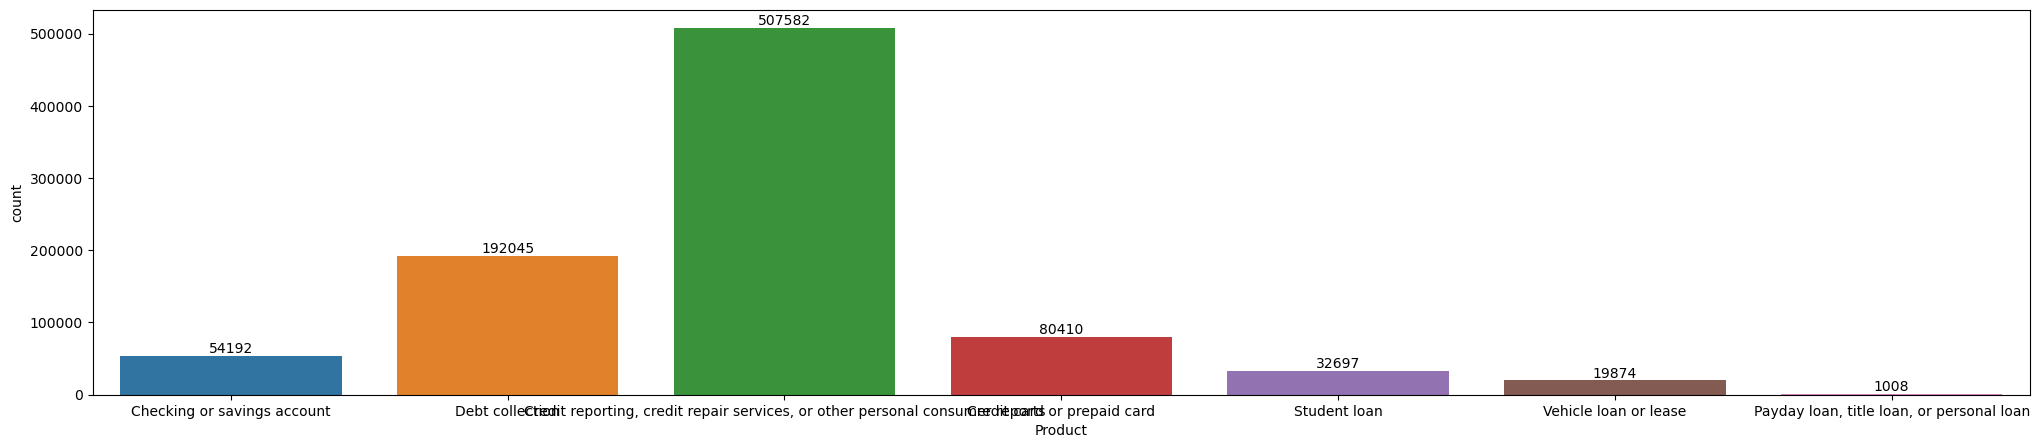

In [7]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['Product'])
ax.bar_label(ax.containers[0])

### 3.2. Processing Columns

In [4]:
data = data[(data['Product'] != 'Payday loan, title loan, or personal loan') & 
            (data['Product'] != 'Credit reporting, credit repair services, or other personal consumer reports')]
data['Product'].value_counts()

Debt collection                192045
Credit card or prepaid card     80410
Checking or savings account     54192
Student loan                    32697
Vehicle loan or lease           19874
Name: Product, dtype: int64

In [6]:
def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in nltk_stopword]
    text = " ".join(text)
    # text = [stemmer.stem(word) for word in text.split(' ')]
    # text=" ".join(text)
    return text
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)  # convert to lower case and tokenize
    words = [word for word in words if word.isalnum()]  # filter out non-alphanumeric characters
    words = [lemmatize_word(word) for word in words]  # lemmatize each word
    return ' '.join(words)  # join the lemmatized words back into a sentence


stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [7]:
data['clean_text'] = data['Consumer complaint narrative'] \
                    .progress_apply(clean) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/379218 [00:00<?, ?it/s]

  0%|          | 0/379218 [00:00<?, ?it/s]

,Product,Consumer complaint narrative,clean_text
3,Checking or savings account,"Hi, I have been banking with Wells Fargo for o...",hi bank well fargo decade within past years gr...
11,Debt collection,XXXX is attempting to collect funds for Valuat...,xxxx attempt collect fund valuations service p...
311,Debt collection,"This auto loan is in error, as my Wife passed ...",auto loan error wife pass away tuesday dispute...
444,Debt collection,"XXXX, Wells Fargo and XXXX were all harassing ...",xxxx well fargo xxxx harass make minimal payme...
529,Checking or savings account,I had a checking account in this bank for over...,check account bank years set automatic payment...


<Axes: xlabel='text_len'>

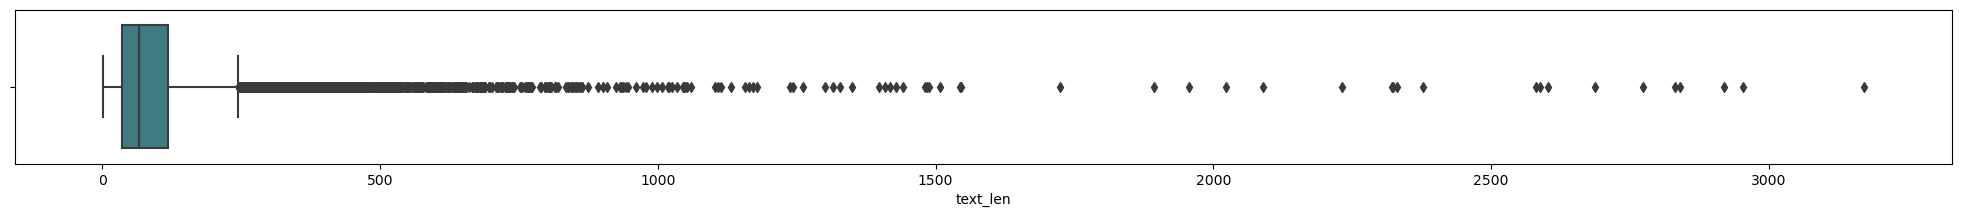

In [8]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [9]:
print(data['text_len'].quantile(0.25))
print(data['text_len'].quantile(0.95))

35.0
286.0


<Axes: xlabel='text_len'>

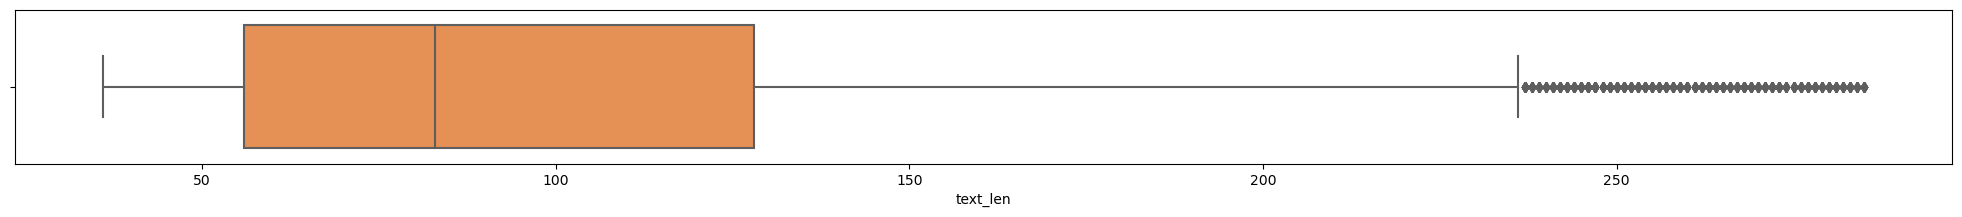

In [10]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(0.95)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

[Text(0, 0, '9672'),
 Text(0, 0, '5014'),
 Text(0, 0, '6013'),
 Text(0, 0, '1348'),
 Text(0, 0, '1281')]

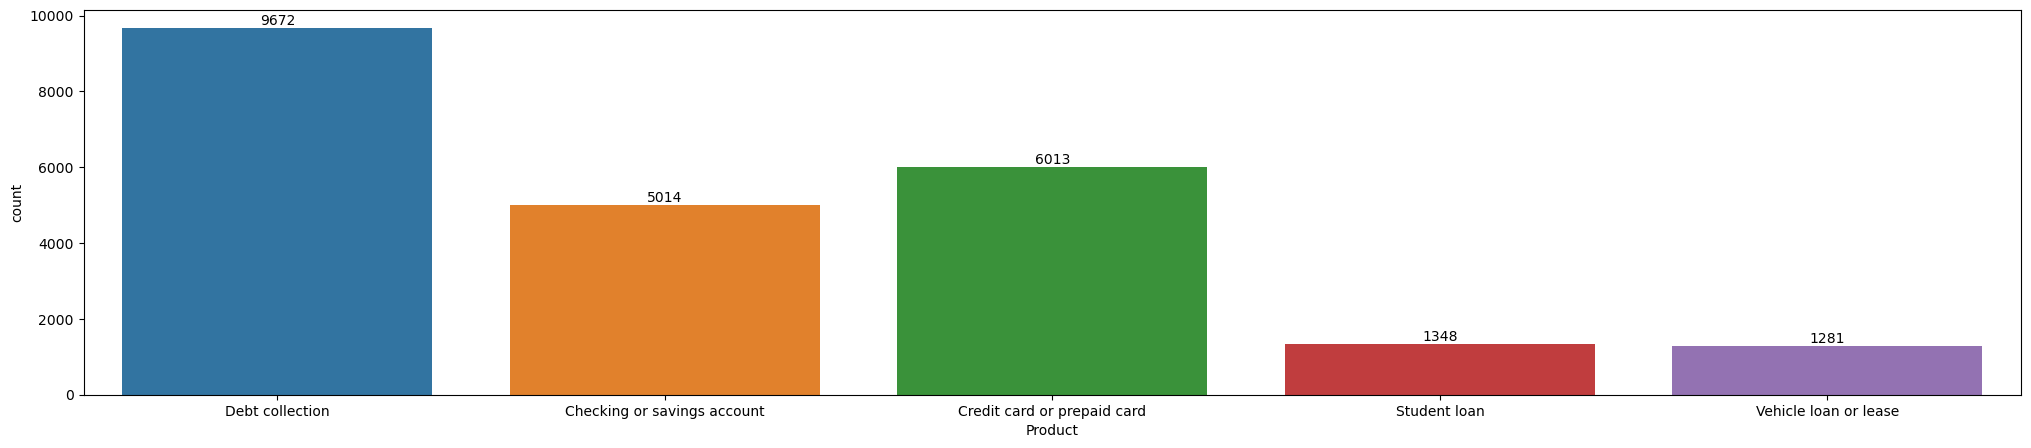

In [11]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['Product'])
ax.bar_label(ax.containers[0])

# 4. Preparing Dataset

In [12]:
LE = LabelEncoder()

X = data['clean_text']
# Y = LE.fit_transform(data['Product']) ### For Classification Algoritms
Y = pd.get_dummies(data['Product']) ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(16376,)
(4619,)
(2333,)


In [14]:
vocab_size = 10000
embedding_dim = 256
max_length = 286
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [13]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

25766


In [15]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)


27033


# 5. Deep Learning Model

In [28]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(5, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(5, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.01)
opt = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 286, 256)          2560000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2,616,005
Trainable params: 2,616,005
Non-trainable params: 0
_________________________________________________________________


In [33]:
num_epoch = 20
batch_size = 64
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/20
71/71 [==============================] - 4s 47ms/step - loss: 0.0839 - accuracy: 0.9842 - val_loss: 0.7189 - val_accuracy: 0.7952
Epoch 2/20
71/71 [==============================] - 3s 45ms/step - loss: 0.0802 - accuracy: 0.9858 - val_loss: 0.7548 - val_accuracy: 0.7889
Epoch 3/20
71/71 [==============================] - 3s 47ms/step - loss: 0.0774 - accuracy: 0.9858 - val_loss: 0.7348 - val_accuracy: 0.7905
Epoch 4/20
71/71 [==============================] - 3s 46ms/step - loss: 0.0733 - accuracy: 0.9869 - val_loss: 0.7354 - val_accuracy: 0.7873
Epoch 5/20
71/71 [==============================] - 3s 47ms/step - loss: 0.0681 - accuracy: 0.9878 - val_loss: 0.7475 - val_accuracy: 0.7889
Epoch 6/20
71/71 [==============================] - 3s 47ms/step - loss: 0.0665 - accuracy: 0.9887 - val_loss: 0.7601 - val_accuracy: 0.7746
Epoch 7/20
71/71 [==============================] - 4s 50ms/step - loss: 0.0705 - accuracy: 0.9853 - val_loss: 0.7588 - val_accuracy: 0.7698
Epoch 8/20
71

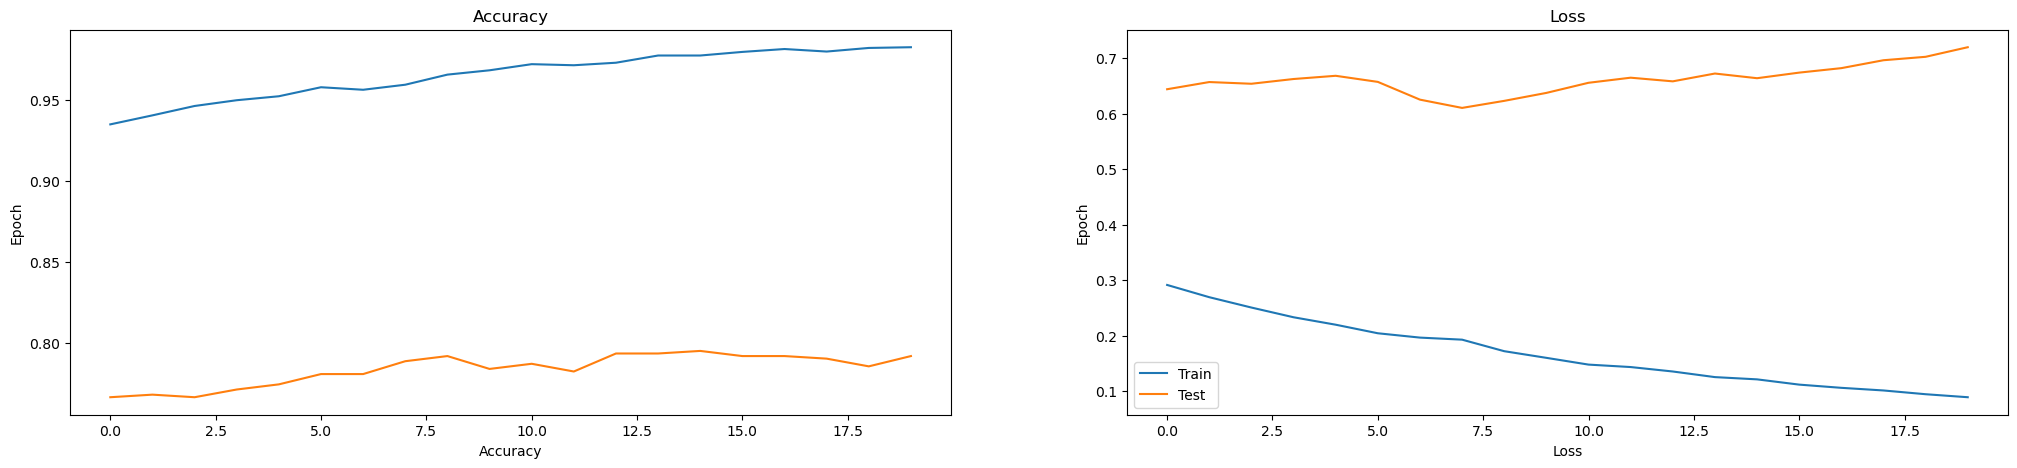

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [39]:
train_predictions = model.predict(testing_padded, verbose=0).argmax(axis=1)

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  0        0     0
1                  0        0     0
2                  0        0     0
3                  0        0     0
4                  0        0     0
401 / 1175


In [40]:
y_pred = np.rint(model.predict(testing_padded, verbose=0))
print(classification_report(testing_label,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       235
           1       0.67      0.74      0.70       235
           2       0.77      0.74      0.76       235
           3       0.91      0.88      0.89       235
           4       0.84      0.76      0.80       235

   micro avg       0.79      0.78      0.79      1175
   macro avg       0.80      0.78      0.79      1175
weighted avg       0.80      0.78      0.79      1175
 samples avg       0.78      0.78      0.78      1175



c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


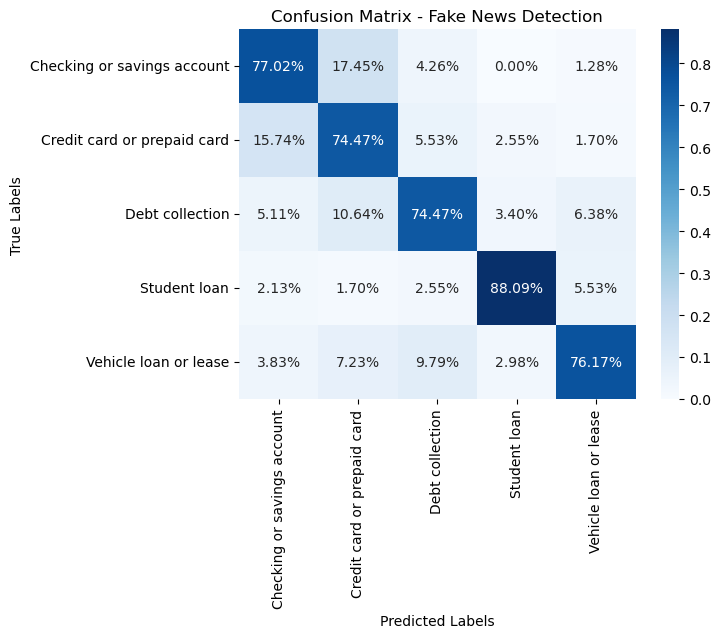

In [43]:
labels = ['Checking or savings account','Credit card or prepaid card', 'Debt collection', 'Student loan', 'Vehicle loan or lease']

y_pred = np.rint(model.predict(testing_padded, verbose=0))
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred.argmax(axis=1))

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [66]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    # ('XGB', XGB),
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTress', extraTrees),
    # ('randomforest', randomForest),
    # ('histGradientBoosting', histGradientBoosting),
    # ('knn', knn),
    # ('decisionTree', decisionTree),
    ('gradient', gradient),

], n_jobs=-1)

In [67]:
model.fit(training_padded, training_label)

In [62]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 99.98 %
Test Score         : 26.94 %
R Squared Error    : -0.97
Mean Squared Error : 3.93


In [63]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  1        0     1
1                  2        0     2
2                  4        0     4
3                  1        0     1
4                  2        0     2
1850 / 1225


In [64]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.20      0.26      0.23       185
           1       0.28      0.27      0.27       260
           2       0.31      0.31      0.31       248
           3       0.03      0.58      0.05        12
           4       0.52      0.25      0.33       520

    accuracy                           0.27      1225
   macro avg       0.27      0.33      0.24      1225
weighted avg       0.38      0.27      0.30      1225



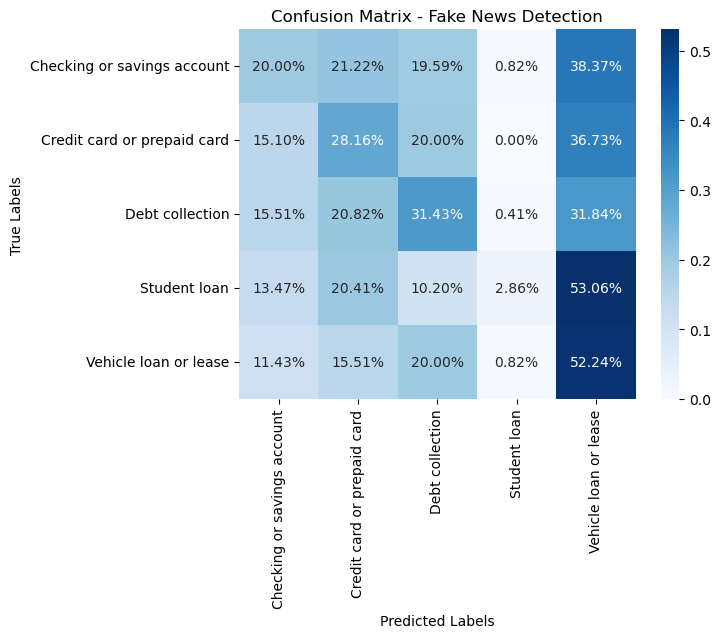

In [65]:
labels = LE.classes_

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()